In [2]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pixell

import sys
sys.path.append('../../ThumbStack')

from cmb import StageIVCMB

import flat_map
from flat_map import *

import catalog
from catalog import *

import universe
from universe import *

import mass_conversion
from mass_conversion import *

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/theo/.local/lib/python3.8/site-packages/pixell/fft.py", line 77, in <module>
    engines['fftw'].FFTW(np.zeros((1,1,1)), np.zeros((1,1,1), dtype=np.complex128),
RuntimeError: Undefined plan with nthreads. This is a bug


In [3]:
import matplotlib as mpl
# set some plotting defaults
mpl.rc(('lines', 'axes') , linewidth=2)
mpl.rc(('xtick', 'ytick'), labelsize=15)
mpl.rc(('xtick.major', 'ytick.major'), width=2)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.serif'] = ['cm'] + mpl.rcParams['font.serif']
# mpl.rcParams["font.family"] = "Times New Roman" 
mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['font.size'] = 18
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [8]:
# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# number of pixels for the flat map, let's do 0.5' pixels
nX = int(sizeX*60.*2.)
nY = int(sizeY*60.*2.)

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
# reminder: l=100 ~ 1 degree
lMin = 30.; lMax = 8000.

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

# order: [[ra_min, dec_max], [ra_max, dec_min]]
box = np.array([[10., 210.], [20., 200.]]) * utils.degree
#box = np.array([[-5., 0.], [0., 5.]]) * utils.degree
resArcmin = 0.5 #1. #0.5  # 0.1   # map pixel size [arcmin]
shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='car')

# create a mask that keeps the whole area
boxMask = enmap.ones(shape, wcs=wcs)
pixsizemap = boxMask.pixsizemap()

89.23577240438216 22.34002769660062 8098.743248089867 8013.9237781951115 7809.790827383111 7729.167004512778


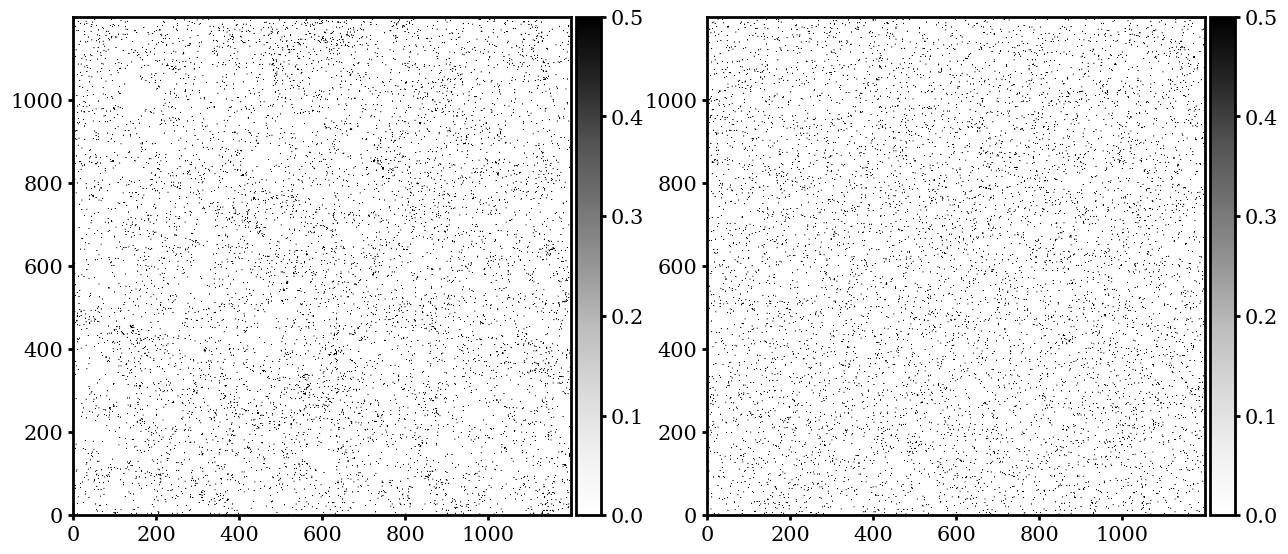

In [13]:
cmass_d = fitsio.read('../output/catalog/cmass_m_10x10_sig5/mock_count_dirac_car.fits')
rand_d = fitsio.read('../output/catalog/cmass_m_10x10_sig5_randradec/mock_count_dirac_car.fits')
fig, axs = plt.subplots(1,2, figsize=(15,7))
im0 = axs[0].imshow(cmass_d, cmap='Greys', origin='lower', vmin=0, vmax=0.5)
im1 = axs[1].imshow(rand_d, cmap='Greys', origin='lower', vmin=0, vmax=0.5)

cbar0 = colorbar(im0)
cbar1 = colorbar(im1)
print(np.max(cmass_d), np.max(rand_d), np.sum(cmass_d/4), np.sum(rand_d/4),
      np.sum(pixsizemap * cmass_d *(180. * 60./np.pi)**2),
      np.sum(pixsizemap * rand_d *(180. * 60./np.pi)**2))

0.2622351665793163 0.1697078646810619 7915.182884163579 7908.205220663993 7632.343787068818 7627.405684260038


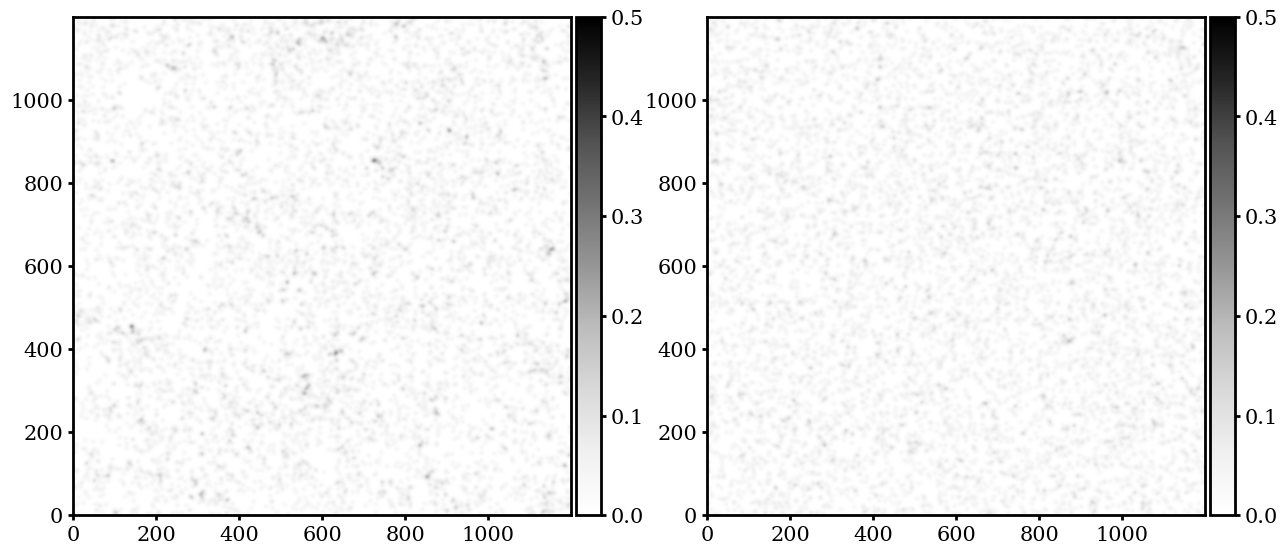

In [14]:
cmass = fitsio.read('../output/catalog/cmass_m_10x10_sig5/mock_count_gauss_car.fits')
rand = fitsio.read('../output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car.fits')
fig, axs = plt.subplots(1,2, figsize=(15,7))
im0 = axs[0].imshow(cmass, cmap='Greys', origin='lower', vmin=0, vmax=0.5)
im1 = axs[1].imshow(rand, cmap='Greys', origin='lower', vmin=0, vmax=0.5)

cbar0 = colorbar(im0)
cbar1 = colorbar(im1)
print(np.max(cmass), np.max(rand), np.sum(cmass/4), np.sum(rand/4),
      np.sum(pixsizemap * cmass *(180. * 60./np.pi)**2),
      np.sum(pixsizemap * rand *(180. * 60./np.pi)**2))

In [70]:
fwhm = 5.
sigma = fwhm / np.sqrt(8.*np.log(2))
denorm = 2. * np.pi * sigma**2
peaktau = 2.45e-4
cmask = cmass > 0
rmask = rand > 0
print(np.sum(pixsizemap * cmass *(180. * 60./np.pi)**2),
      np.sum(pixsizemap * rand *(180. * 60./np.pi)**2),
      np.sum(denorm * pixsizemap * cmass *(180. * 60./np.pi)**2),
      np.sum(denorm * pixsizemap * rand *(180. * 60./np.pi)**2),
      np.sum(peaktau * denorm * pixsizemap * cmass *(180. * 60./np.pi)**2),
      np.sum(peaktau * denorm * pixsizemap * rand *(180. * 60./np.pi)**2),
      np.mean(peaktau * denorm * pixsizemap[cmask] * cmass[cmask] *(180. * 60./np.pi)**2),
      np.mean(peaktau * denorm * pixsizemap[rmask] * rand[rmask] *(180. * 60./np.pi)**2))

7632.343787068818 7627.405684260038 216203.31730770718 216063.43443053984 52.96981274038824 52.93554143548226 3.699520795500234e-05 3.677675479668762e-05


In [71]:
countGauss = cmass * 2 * np.pi * sigma**2
countGauss *= peaktau
pixsizemap_amin = pixsizemap * (180. * 60. / np.pi)**2
print(fwhm, sigma)
print(np.sum(countGauss * pixsizemap_amin))
print(7676 * peaktau * 2 * np.pi * sigma**2)

5.0 2.1233045007200477
52.96981274038824
53.27279456201911


In [72]:
countGauss_r = rand * 2 * np.pi * sigma**2
countGauss_r *= peaktau
pixsizemap_amin = pixsizemap * (180. * 60. / np.pi)**2
print(fwhm, sigma)
print(np.sum(countGauss_r * pixsizemap_amin))
print(7676 * peaktau * 2 * np.pi * sigma**2)

5.0 2.1233045007200477
52.935541435482264
53.27279456201911


In [76]:
fitsio.write('../output/catalog/cmass_m_10x10_sig5/mock_count_gauss_car_renorm2.45e-4_nobeam.fits', countGauss)
fitsio.write('../output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car_renorm2.45e-4_nobeam.fits', countGauss_r)

1.0021095222004235
0.06135850377421375 1.0021095222004235


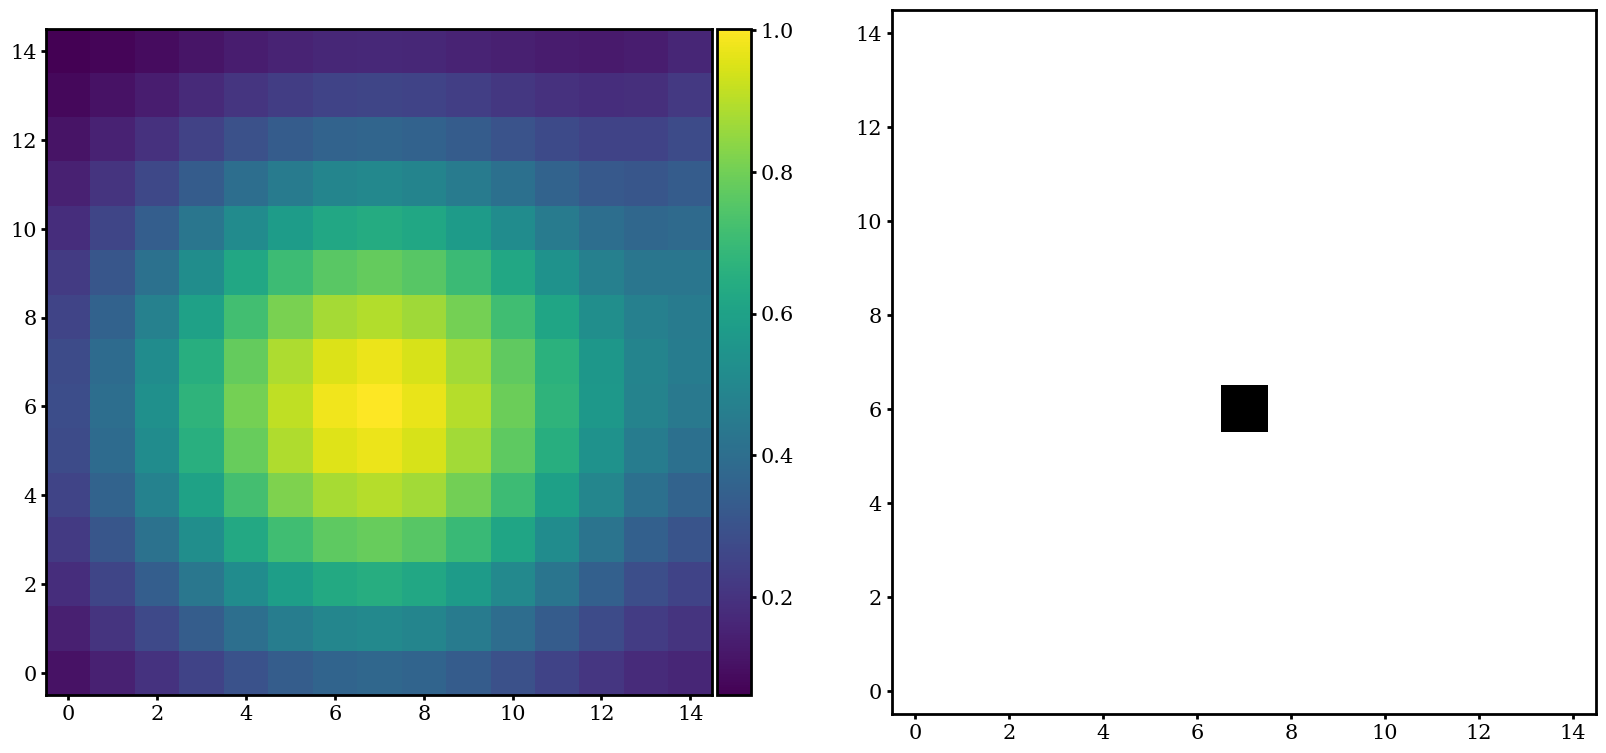

In [73]:
tau_unnorm = 1/peaktau
d = countGauss_r.copy()
d = np.array(d.data) * tau_unnorm # * pixsizemap_amin
corner = (460, 144)
slicestart = corner[1] + 8
bside = 15
vmax = 2.
fig, axs = plt.subplots(1, 2, figsize=(20,10))
stamp = d[corner[1]:corner[1]+bside,corner[0]:corner[0]+bside]
print(np.max(stamp))
# stamp_d = cmass_d[corner[1]:corner[1]+bside,corner[0]:corner[0]+bside]
stamp_d = rand_d[corner[1]:corner[1]+bside,corner[0]:corner[0]+bside]
# hslice = d[slicestart:slicestart+1,corner[0]:corner[0]+bside]
# print(hslice)
# hslice[:, :] = np.array(range(bside)) / bside
# print(hslice)
print(np.min(stamp), np.max(stamp))
im = axs[0].imshow(stamp, origin='lower')
c = colorbar(im)
im1 = axs[1].imshow(stamp_d, cmap='Greys', origin='lower', vmin=0, vmax=1)
# c = colorbar(im1)
# im2 = axs[2].imshow(d, origin='lower')
# c = colorbar(im2)

In [8]:
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

In [9]:
cmassGaussFourier = baseMap.fourier(cmass_gauss)

In [10]:
randGaussFourier = baseMap.fourier(rand_gauss)

/home/theo/Documents/research/CMB/tau_sims/notebooks/../../ThumbStack/flat_map.py:459: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


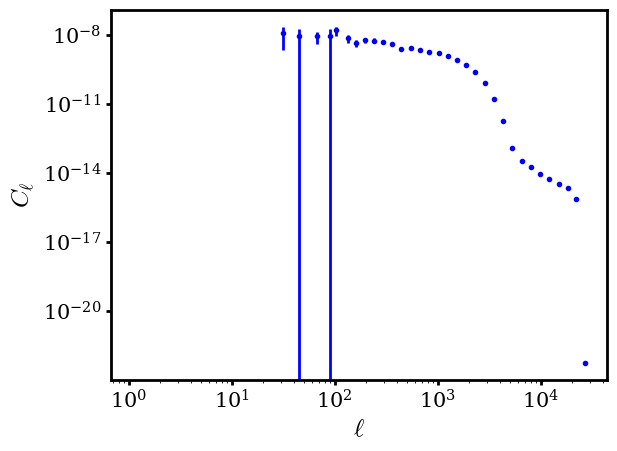

In [11]:
ell, cl, scl = baseMap.powerSpectrum(cmassGaussFourier, plot=True)

In [12]:
f = interp1d(ell, cl, kind='linear', bounds_error=False, fill_value=0)

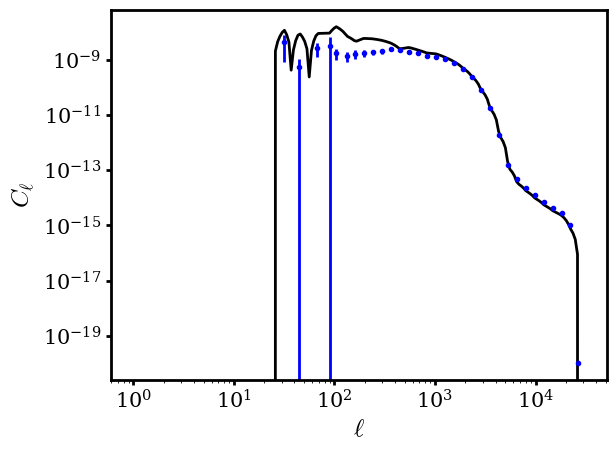

In [13]:
ell, clr, sclr = baseMap.powerSpectrum(randGaussFourier, plot=True, theory=[f])

In [14]:
cmass_gauss_normed = cmass_gauss/np.max(cmass_gauss)
rand_gauss_normed = rand_gauss/np.max(rand_gauss)

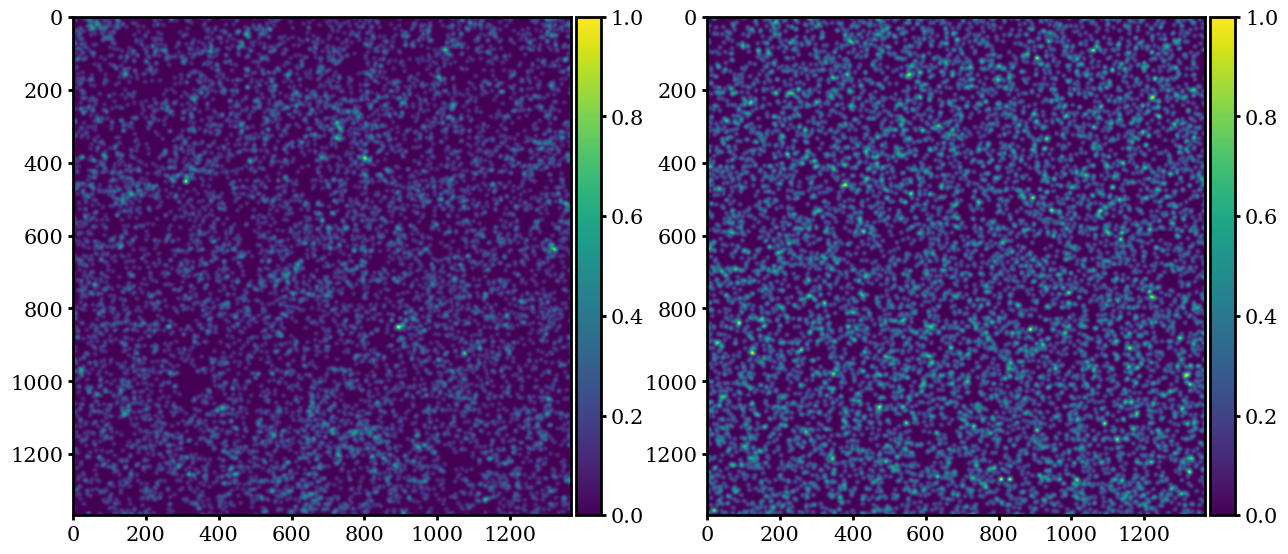

In [15]:
fig, axs = plt.subplots(1,2, figsize=(15,40))
im0 = axs[0].imshow(cmass_gauss_normed, cmap='viridis')
im1 = axs[1].imshow(rand_gauss_normed, cmap='viridis')
cbar0 = colorbar(im0)
cbar1 = colorbar(im1)

In [16]:
# fitsio.write('output/catalog/cmass_m_10x10_v2/cmass_m_10x10_v2_mock_count_gauss_car_normed.fits', cmass_gauss_normed)
# fitsio.write('output/catalog/cmass_m_10x10_randradec_v2/cmass_m_10x10_randradec_v2_mock_count_gauss_car_normed.fits', rand_gauss_normed)

In [18]:
cmassGaussFourier_n = baseMap.fourier(cmass_gauss_normed)

In [19]:
randGaussFourier_n = baseMap.fourier(rand_gauss_normed)

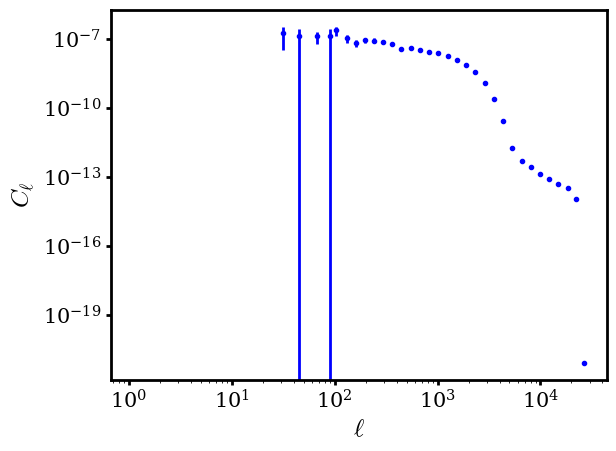

In [20]:
ell, cl, scl = baseMap.powerSpectrum(cmassGaussFourier_n, plot=True)

In [21]:
f = interp1d(ell, cl, kind='linear', bounds_error=False, fill_value=0)

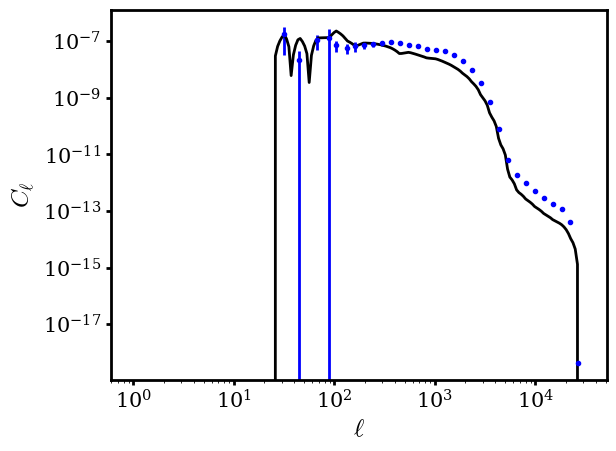

In [22]:
ell, clr, sclr = baseMap.powerSpectrum(randGaussFourier_n, plot=True, theory=[f])

## Checking correct RA/DEC orientation

### 3/22/2023: Found bug: was using transpose of tau field to make CMB+tau maps RIP!!!
### BUG REDACTED. EVERYTHING'S FINE.
#### Now checking manually that positions match between created maps and catalog RA/DEC values

In [23]:
rand_dir = '/home/theo/Documents/research/CMB/tau_sims/output/catalog/cmass_m_10x10_randradec_v2'
diracpath = os.path.join(rand_dir, 'cmass_m_10x10_randradec_v2mock_count_dirac_car.fits')
gausspath = os.path.join(rand_dir, 'cmass_m_10x10_randradec_v2mock_count_gauss_car.fits')
diracMap = baseMap.copy()
gaussMap = baseMap.copy()
dData = fitsio.read(diracpath)
gData = fitsio.read(gausspath)
diracMap.data = dData
gaussMap.data = gData
diracEnmap = enmap.enmap(diracMap.data, wcs)
gaussEnmap = enmap.enmap(gaussMap.data, wcs)
pixell.enplot.pshow(diracEnmap)
pixell.enplot.pshow(gaussEnmap)

OSError: FITSIO status = 104: could not open the named file
failed to find or open the following file: (ffopen)
/home/theo/Documents/research/CMB/tau_sims/output/catalog/cmass_m_10x10_randrade
c_v2/cmass_m_10x10_randradec_v2mock_count_dirac_car.fits


#### looks like pixell does the customary ra[ra>180] -= 360.

In [24]:
## Compare to RA/DEC positions from the catalog itself
nProc = 1
u = Universe()
massConversion = MassConversionKravtsov14()
cmass_10x10_rand = Catalog(u, massConversion, name="cmass_m_10x10_randradec_v2")
fig, ax = plt.subplots(1,1, figsize=(20,20))
plt.scatter(cmass_10x10_rand.RA, cmass_10x10_rand.DEC, s=15)
plt.gca().invert_xaxis()

- load full catalog from ./output/catalog/cmass_m_10x10_randradec_v2/catalog.txt


FileNotFoundError: ./output/catalog/cmass_m_10x10_randradec_v2/catalog.txt not found.

Matches up now yay!

40000.0 8.0 41438.97113402401 3468176308989.432 41830.1743025302 0.2622351665792444


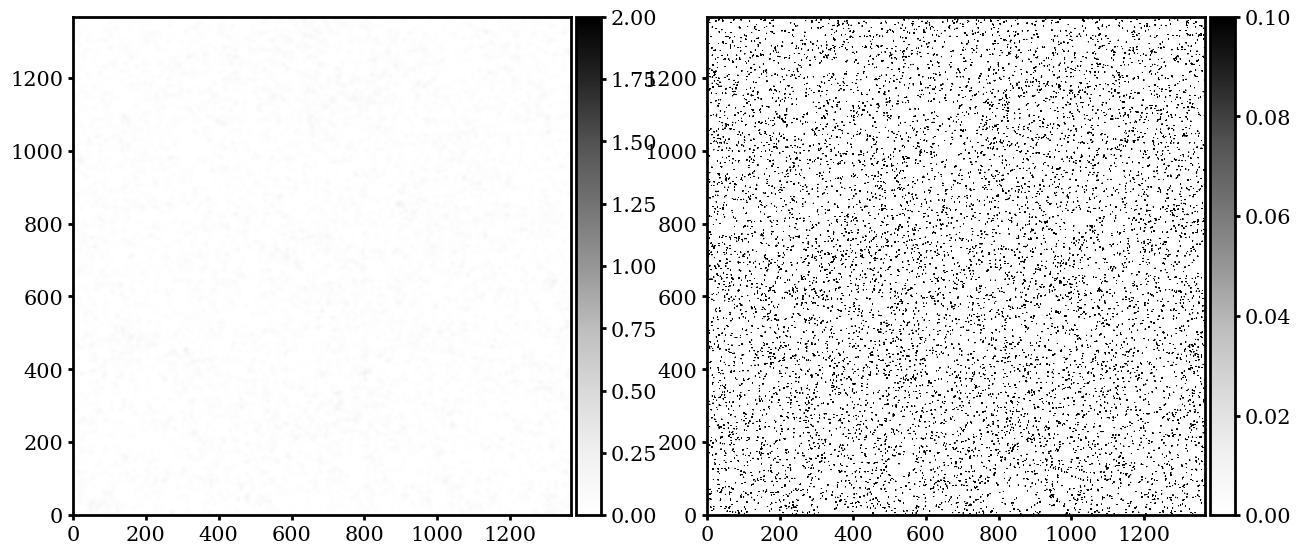

In [25]:
dirac = fitsio.read('../output/catalog/cmass_m_10kgal_sig5/mock_count_dirac_car.fits')
cmass = fitsio.read('../output/catalog/cmass_m_10kgal_sig5/mock_count_gauss_car.fits')
nx, ny = cmass.shape
rng = np.random.default_rng(42)
x, y = rng.choice(range(nx), 10000), rng.choice(range(ny), 10000)
norm = 2.*np.pi*(5./np.sqrt(8.*np.log(2.)))**2 * 0.25 * (180.*60./np.pi)**2
ncmass = norm * cmass
newmap = np.zeros_like(cmass)
for xi,yi in zip(x,y):
    newmap[xi,yi] += 4. # integrates to 1 / arcmin^2
print(np.sum(newmap), np.max(newmap), np.sum(cmass), np.sum(ncmass), np.sum(rand), np.max(cmass))

fig, axs = plt.subplots(1,2, figsize=(15,7))
im0 = axs[0].imshow(cmass, cmap='Greys', origin='lower', vmin=0, vmax=2.)
im1 = axs[1].imshow(newmap, cmap='Greys', origin='lower', vmin=0, vmax=0.1)
# axs.set_xticks([])
# axs.set_yticks([])
cbar0 = colorbar(im0)
cbar1 = colorbar(im1)

(array([1.871371e+06, 0.000000e+00, 5.200000e+01, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([ 0.        ,  8.92357724, 17.84715448, 26.77073172, 35.69430896,
        44.6178862 , 53.54146344, 62.46504068, 71.38861792, 80.31219516,
        89.2357724 ]),
 <BarContainer object of 10 artists>)

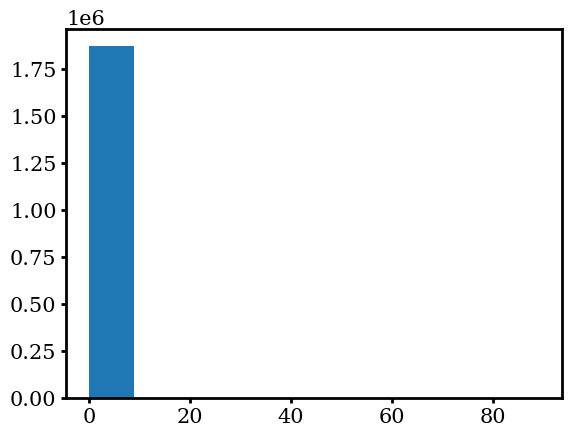

In [26]:
plt.hist(dirac.flatten())

In [27]:
fm = baseMap.copy()
fm.data = newmap
fm.dataFourier = fm.fourier(newmap)

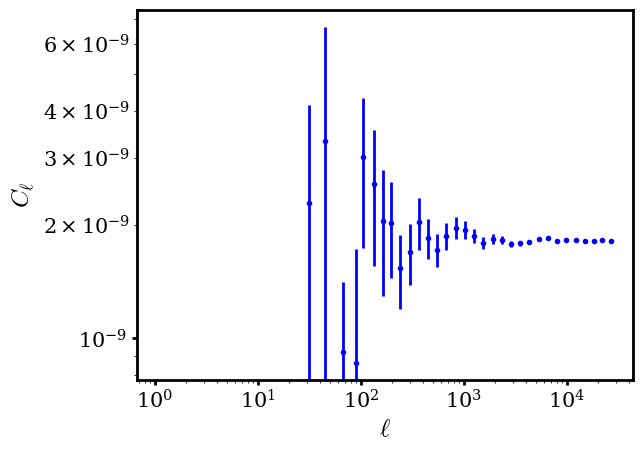

(array([1.11470873e+00, 1.37044237e+00, 1.68484577e+00, 2.07137880e+00,
        2.54658925e+00, 3.13082128e+00, 3.84908633e+00, 4.73213392e+00,
        5.81776804e+00, 7.15246558e+00, 8.79336603e+00, 1.08107177e+01,
        1.32908850e+01, 1.63400461e+01, 2.00887378e+01, 2.46974450e+01,
        3.15789474e+01, 3.73293799e+01, 4.46593757e+01, 5.64221363e+01,
        6.74177680e+01, 8.93187513e+01, 1.03554016e+02, 1.33278334e+02,
        1.61972078e+02, 1.95425811e+02, 2.40456517e+02, 2.96286860e+02,
        3.62216045e+02, 4.45281464e+02, 5.49765810e+02, 6.76489775e+02,
        8.30165692e+02, 1.02165278e+03, 1.25597232e+03, 1.54176122e+03,
        1.89514442e+03, 2.33104639e+03, 2.86620531e+03, 3.52357283e+03,
        4.33191956e+03, 5.32612496e+03, 6.54776747e+03, 8.04940101e+03,
        9.89622827e+03, 1.21663226e+04, 1.49575459e+04, 1.83889132e+04,
        2.21396853e+04, 2.66969892e+04]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [28]:
fm.powerSpectrum(plot=True)

In [29]:
from functools import partial

def fbeam(ell, real_fwhm):
    real_sigma = real_fwhm / np.sqrt(8.*np.log(2.))
    return np.exp(-0.5*(ell * real_sigma)**2)

def apply_beam(flatmap, fwhm=1.6):
    print('Applying beam with FWHM=%s arcmin.'%str(fwhm))
    # convert fwhm from arcmin to radians
    fwhm_rad = fwhm * np.pi / 180. / 60.
    # v1
    beamfn = partial(fbeam, real_fwhm=fwhm_rad)
    flatmap.dataFourier = flatmap.filterFourierIsotropic(fW=beamfn)
    # v2
    # flatmap.dataFourier *= fbeam(flatmap.l, fwhm_rad)
    flatmap.data = flatmap.inverseFourier()
    flatmap.name += '_beam%s'%str(fwhm)
    
    return flatmap

In [30]:
fm1 = apply_beam(fm, fwhm=5.)

Applying beam with FWHM=5.0 arcmin.


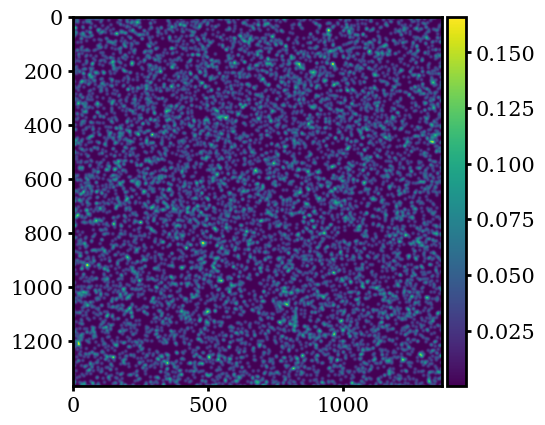

In [31]:
im = plt.imshow(fm1.data)
cbar = colorbar(im)

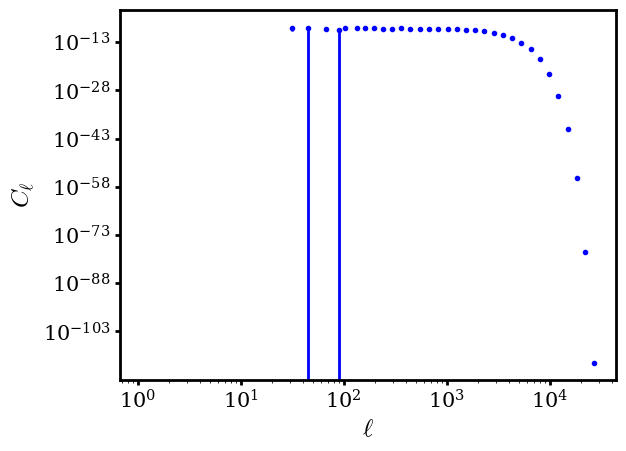

(array([1.11470873e+00, 1.37044237e+00, 1.68484577e+00, 2.07137880e+00,
        2.54658925e+00, 3.13082128e+00, 3.84908633e+00, 4.73213392e+00,
        5.81776804e+00, 7.15246558e+00, 8.79336603e+00, 1.08107177e+01,
        1.32908850e+01, 1.63400461e+01, 2.00887378e+01, 2.46974450e+01,
        3.15789474e+01, 3.73293799e+01, 4.46593757e+01, 5.64221363e+01,
        6.74177680e+01, 8.93187513e+01, 1.03554016e+02, 1.33278334e+02,
        1.61972078e+02, 1.95425811e+02, 2.40456517e+02, 2.96286860e+02,
        3.62216045e+02, 4.45281464e+02, 5.49765810e+02, 6.76489775e+02,
        8.30165692e+02, 1.02165278e+03, 1.25597232e+03, 1.54176122e+03,
        1.89514442e+03, 2.33104639e+03, 2.86620531e+03, 3.52357283e+03,
        4.33191956e+03, 5.32612496e+03, 6.54776747e+03, 8.04940101e+03,
        9.89622827e+03, 1.21663226e+04, 1.49575459e+04, 1.83889132e+04,
        2.21396853e+04, 2.66969892e+04]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000

In [32]:
fm1.powerSpectrum(plot=True)

In [33]:
d = fm1.data.copy()

In [34]:
print(np.sum(d), np.max(d), 2 / (np.max(d) * norm))

39999.99999999998 0.16600564062772963 1.439510865934938e-07


In [35]:
fwhm = 5.0
sigma = fwhm / np.sqrt(8*np.log(2))
fwhm_rad = fwhm * np.pi / 180. / 60. 
sigma_rad = fwhm_rad / np.sqrt(8.*np.log(2.))
print(sigma, 1/sigma)
norm = 4. * 2*np.pi * sigma**2
print(np.max(d), np.max(d)*norm)

2.1233045007200477 0.47096400900618984
0.16600564062772963 18.80993372249027


0.04101722162921919 4.004722363210826


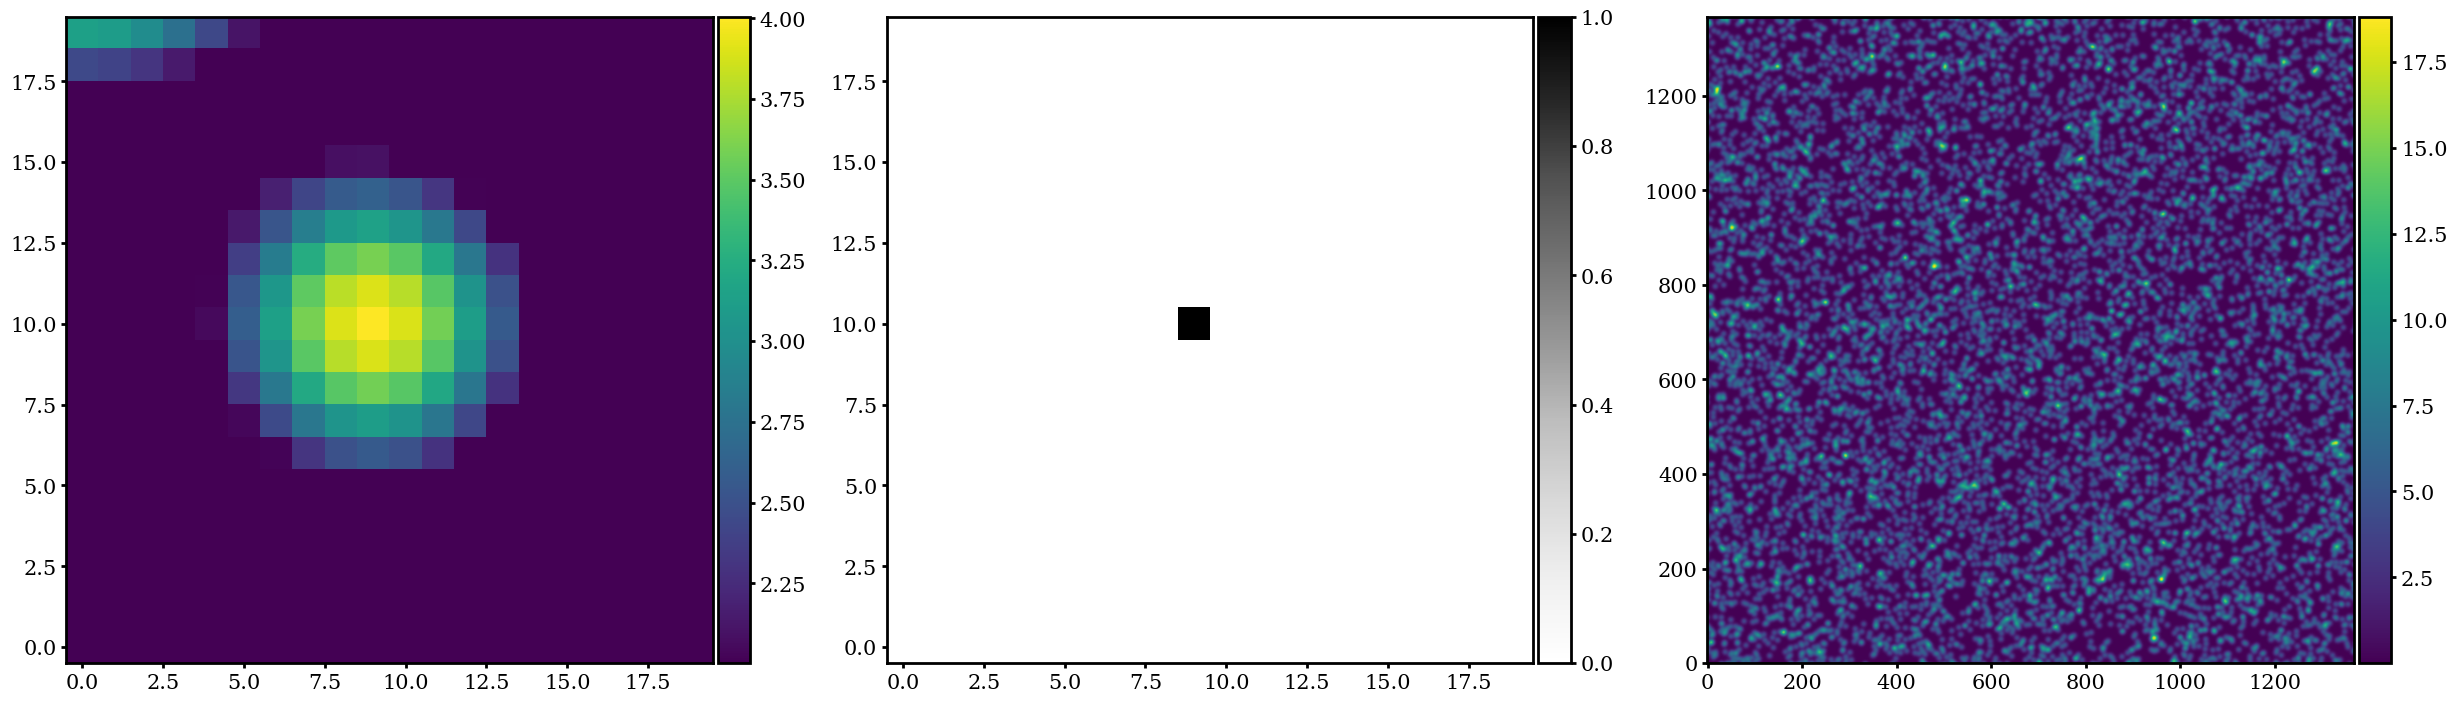

In [36]:
# tau_norm = 2.56e-4
d = fm1.data.copy() * norm
corner = (184, 172)
slicestart = corner[1] + 8
bside = 20
vmax = 2.
fig, axs = plt.subplots(1, 3, figsize=(30,10))
stamp = d[corner[1]:corner[1]+bside,corner[0]:corner[0]+bside]
# hslice = d[slicestart:slicestart+1,corner[0]:corner[0]+bside]
# print(hslice)
# hslice[:, :] = np.array(range(bside)) / bside
# print(hslice)
print(np.min(stamp), np.max(stamp))
im = axs[0].imshow(stamp, vmin=np.max(stamp)/2, origin='lower')
c = colorbar(im)
im1 = axs[1].imshow(newmap[corner[1]:corner[1]+bside,corner[0]:corner[0]+bside],
                    cmap='Greys', origin='lower', vmin=0, vmax=1)
c = colorbar(im1)
im2 = axs[2].imshow(d, origin='lower')
c = colorbar(im2)

In [37]:
unnorm_gauss = fm1.copy()
unnorm_gauss.data = d
unnorm_gauss.dataFourier = unnorm_gauss.fourier(d)
unnorm_gauss.name = '10kgal_gauss_peak1'

In [38]:
unnorm_gauss.pixsizemap()

AttributeError: 'FlatMap' object has no attribute 'pixsizemap'

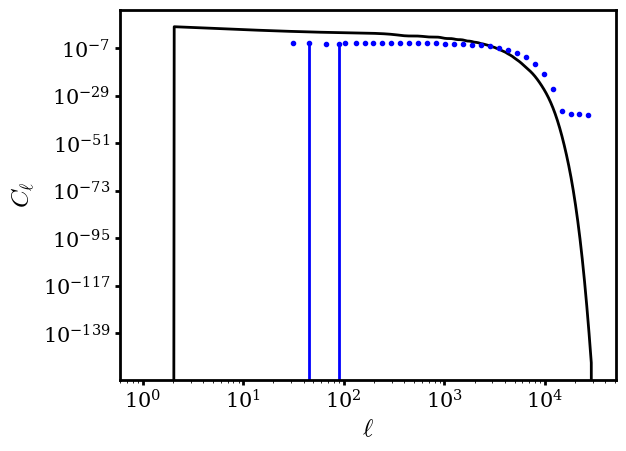

(array([1.11470873e+00, 1.37044237e+00, 1.68484577e+00, 2.07137880e+00,
        2.54658925e+00, 3.13082128e+00, 3.84908633e+00, 4.73213392e+00,
        5.81776804e+00, 7.15246558e+00, 8.79336603e+00, 1.08107177e+01,
        1.32908850e+01, 1.63400461e+01, 2.00887378e+01, 2.46974450e+01,
        3.15789474e+01, 3.73293799e+01, 4.46593757e+01, 5.64221363e+01,
        6.74177680e+01, 8.93187513e+01, 1.03554016e+02, 1.33278334e+02,
        1.61972078e+02, 1.95425811e+02, 2.40456517e+02, 2.96286860e+02,
        3.62216045e+02, 4.45281464e+02, 5.49765810e+02, 6.76489775e+02,
        8.30165692e+02, 1.02165278e+03, 1.25597232e+03, 1.54176122e+03,
        1.89514442e+03, 2.33104639e+03, 2.86620531e+03, 3.52357283e+03,
        4.33191956e+03, 5.32612496e+03, 6.54776747e+03, 8.04940101e+03,
        9.89622827e+03, 1.21663226e+04, 1.49575459e+04, 1.83889132e+04,
        2.21396853e+04, 2.66969892e+04]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [36]:
# check 5 arcmin profile
cmb = StageIVCMB(beam=5., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)
f = lambda l: cmb.funlensedTT(l) * cmb.fbeam(l)**2
unnorm_gauss.powerSpectrum(plot=True, theory=[f])

In [37]:
def save_flatmap(flatmap, path=None, save_diagnostics=True):
    if save_diagnostics:
        ell_max = np.max(flatmap.l.flatten())
        ps_path = os.path.join(path, '%s_powspec.png'%flatmap.name)
        print('Saving power spectrum plot:', ps_path)
        flatmap.powerSpectrum(nBins=int(ell_max/200), lRange=[1., ell_max],
            plot=True, save=True, path=ps_path)
        map_path = os.path.join(path, '%s_map.png'%flatmap.name)
        print('Saving map image:', map_path)
        flatmap.plot(save=True, title=flatmap.name, path=map_path)
    fm_path = os.path.join(path, '%s_flatmap.fits'%flatmap.name)
    print('Saving flatmap:', fm_path)
    flatmap.write(fm_path)

In [ ]:
# save_flatmap(unnorm_gauss, 'output/tau_maps/10kgal_fwhm5_randradec/10kgal_gauss_peak1')